In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/um-game-playing-strength-of-mcts-variants/sample_submission.csv
/kaggle/input/um-game-playing-strength-of-mcts-variants/train.csv
/kaggle/input/um-game-playing-strength-of-mcts-variants/test.csv
/kaggle/input/um-game-playing-strength-of-mcts-variants/concepts.csv
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evaluation/mcts_gateway.py
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evaluation/__init__.py
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evaluation/mcts_inference_server.py
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evaluation/core/templates.py
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evaluation/core/base_gateway.py
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evaluation/core/relay.py
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/um-game-playing-strength-of-mcts-variants/kaggle_evalua

In [2]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import KNNImputer
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor
import os
import pyarrow as pa
import pyarrow.parquet as pq
import polars as pl
seed=42
np.random.seed(seed)
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import lightgbm as lgb

## Cleaning 

1. drop column have same values or 90%
1. drop column dont have any meaning or not found on test ["Id", "EnglishRules", "LudRules", "num_wins_agent1", "num_draws_agent1", "num_losses_agent1"]

In [3]:
train_path = "/kaggle/input/um-game-playing-strength-of-mcts-variants/train.csv"
train_data = pd.read_csv(train_path)
train_data

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [4]:
# select columns with 90% or more identical values and columns with all null values
def drop_column_name(df):
    drop_columns = []
    for column in df.columns:
        if df[column].value_counts().max() / len(df) >= 0.90 or df[column].isnull().all():
            drop_columns.append(column)
    return drop_columns

In [5]:
drop_column = drop_column_name(train_data)
#add Column dont have any meaning whene training or not found on test dataset
drop_column.extend(["Id", "EnglishRules", "LudRules", "num_wins_agent1", "num_draws_agent1", "num_losses_agent1"])

In [6]:
train = train_data.drop(columns=drop_column, errors='ignore')

In [7]:
train

,GameRulesetName,agent1,agent2,Asymmetric,AsymmetricForces,AsymmetricPiecesType,PlayersWithDirections,Shape,SquareShape,RegularShape,...,SetSiteState,Variable,SetVar,CopyContext,Then,ForEachPiece,DoLudeme,PlayoutsPerSecond,MovesPerSecond,utility_agent1
0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,0,0,0,0,1,0,0,...,0,1,1,0,1,0,0,298.07,18877.17,-0.466667
1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,0,0,0,0,1,0,0,...,0,1,1,0,1,0,0,298.07,18877.17,-0.333333
2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,0,0,0,0,1,0,0,...,0,1,1,0,1,0,0,298.07,18877.17,-0.066667
3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,0,0,0,0,1,0,0,...,0,1,1,0,1,0,0,298.07,18877.17,-0.333333
4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,0,0,0,0,1,0,0,...,0,1,1,0,1,0,0,298.07,18877.17,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,0,0,0,0,1,1,1,...,0,0,0,0,1,1,0,157.52,157174.58,-0.733333
233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,0,0,0,0,1,1,1,...,0,0,0,0,1,1,0,157.52,157174.58,0.266667
233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,0,0,0,0,1,1,1,...,0,0,0,0,1,1,0,157.52,157174.58,0.666667
233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,0,0,0,0,1,1,1,...,0,0,0,0,1,1,0,157.52,157174.58,0.666667


In [8]:
train_v1=train.copy()

In [9]:
train_v1[['agent1_format','agent1_strategies', 'agent1_EXP_const', 'agent1_PLAYOUT','agent1_SCORE_BOUNDS']] = train_v1['agent1'].str.split('-', expand=True)
train_v1[['agent2_format','agent2_strategies', 'agent2_EXP_const', 'agent2_PLAYOUT','agent2_SCORE_BOUNDS']] = train_v1['agent2'].str.split('-', expand=True)

In [10]:
train_v1 = train_v1.drop(columns=['agent1_format','agent2_format','agent1','agent2'], errors='ignore')

In [11]:
train_v1

,GameRulesetName,Asymmetric,AsymmetricForces,AsymmetricPiecesType,PlayersWithDirections,Shape,SquareShape,RegularShape,PolygonShape,Tiling,...,MovesPerSecond,utility_agent1,agent1_strategies,agent1_EXP_const,agent1_PLAYOUT,agent1_SCORE_BOUNDS,agent2_strategies,agent2_EXP_const,agent2_PLAYOUT,agent2_SCORE_BOUNDS
0,00Y,0,0,0,0,1,0,0,1,1,...,18877.17,-0.466667,ProgressiveHistory,0.1,MAST,false,ProgressiveHistory,0.6,Random200,false
1,00Y,0,0,0,0,1,0,0,1,1,...,18877.17,-0.333333,ProgressiveHistory,0.1,MAST,false,UCB1GRAVE,0.6,NST,true
2,00Y,0,0,0,0,1,0,0,1,1,...,18877.17,-0.066667,ProgressiveHistory,0.1,MAST,true,UCB1,0.1,NST,false
3,00Y,0,0,0,0,1,0,0,1,1,...,18877.17,-0.333333,ProgressiveHistory,0.1,MAST,true,UCB1,0.6,NST,false
4,00Y,0,0,0,0,1,0,0,1,1,...,18877.17,-0.333333,ProgressiveHistory,0.1,MAST,true,UCB1GRAVE,1.41421356237,NST,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,Zuz_Mel_7x7,0,0,0,0,1,1,1,1,1,...,157174.58,-0.733333,UCB1Tuned,1.41421356237,NST,false,ProgressiveHistory,1.41421356237,Random200,false
233230,Zuz_Mel_7x7,0,0,0,0,1,1,1,1,1,...,157174.58,0.266667,UCB1Tuned,1.41421356237,Random200,false,UCB1,0.6,MAST,false
233231,Zuz_Mel_7x7,0,0,0,0,1,1,1,1,1,...,157174.58,0.666667,UCB1Tuned,1.41421356237,Random200,false,UCB1GRAVE,1.41421356237,NST,false
233232,Zuz_Mel_7x7,0,0,0,0,1,1,1,1,1,...,157174.58,0.666667,UCB1Tuned,1.41421356237,Random200,false,UCB1GRAVE,1.41421356237,NST,true


In [12]:
def summarize_dataframe_info(df):
    table=pd.DataFrame(columns=["Column","Data Type","Null count"])
    Dtype=""
    null=0
    for column in df.columns:
        Dtype=df[column].dtype
        null=df[column].isnull().sum()
        new_row = {"Column": column, "Data Type": Dtype,"Null count":null}
        table = pd.concat([table, pd.DataFrame([new_row])], ignore_index=True)
    return table

In [13]:
info=summarize_dataframe_info(train_v1)

In [14]:
info

,Column,Data Type,Null count
0,GameRulesetName,object,0
1,Asymmetric,int64,0
2,AsymmetricForces,int64,0
3,AsymmetricPiecesType,int64,0
4,PlayersWithDirections,int64,0
...,...,...,...
260,agent1_SCORE_BOUNDS,object,0
261,agent2_strategies,object,0
262,agent2_EXP_const,object,0
263,agent2_PLAYOUT,object,0


In [15]:
print(info[info['Null count']>0])
print(info[info['Data Type']=='object'])

Empty DataFrame
Columns: [Column, Data Type, Null count]
Index: []
                  Column Data Type Null count
0        GameRulesetName    object          0
257    agent1_strategies    object          0
258     agent1_EXP_const    object          0
259       agent1_PLAYOUT    object          0
260  agent1_SCORE_BOUNDS    object          0
261    agent2_strategies    object          0
262     agent2_EXP_const    object          0
263       agent2_PLAYOUT    object          0
264  agent2_SCORE_BOUNDS    object          0


In [16]:
info[info['Data Type']=='object']['Column']

0          GameRulesetName
257      agent1_strategies
258       agent1_EXP_const
259         agent1_PLAYOUT
260    agent1_SCORE_BOUNDS
261      agent2_strategies
262       agent2_EXP_const
263         agent2_PLAYOUT
264    agent2_SCORE_BOUNDS
Name: Column, dtype: object

In [17]:
colunm_encoder=info[info['Data Type']=='object']['Column']

In [18]:
for i in colunm_encoder:
    le= LabelEncoder()
    train_v1[i]=le.fit_transform(train_v1[i])

In [19]:
train_v1

,GameRulesetName,Asymmetric,AsymmetricForces,AsymmetricPiecesType,PlayersWithDirections,Shape,SquareShape,RegularShape,PolygonShape,Tiling,...,MovesPerSecond,utility_agent1,agent1_strategies,agent1_EXP_const,agent1_PLAYOUT,agent1_SCORE_BOUNDS,agent2_strategies,agent2_EXP_const,agent2_PLAYOUT,agent2_SCORE_BOUNDS
0,0,0,0,0,0,1,0,0,1,1,...,18877.17,-0.466667,0,0,0,0,0,1,2,0
1,0,0,0,0,0,1,0,0,1,1,...,18877.17,-0.333333,0,0,0,0,2,1,1,1
2,0,0,0,0,0,1,0,0,1,1,...,18877.17,-0.066667,0,0,0,1,1,0,1,0
3,0,0,0,0,0,1,0,0,1,1,...,18877.17,-0.333333,0,0,0,1,1,1,1,0
4,0,0,0,0,0,1,0,0,1,1,...,18877.17,-0.333333,0,0,0,1,2,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,1376,0,0,0,0,1,1,1,1,1,...,157174.58,-0.733333,3,2,1,0,0,2,2,0
233230,1376,0,0,0,0,1,1,1,1,1,...,157174.58,0.266667,3,2,2,0,1,1,0,0
233231,1376,0,0,0,0,1,1,1,1,1,...,157174.58,0.666667,3,2,2,0,2,2,1,0
233232,1376,0,0,0,0,1,1,1,1,1,...,157174.58,0.666667,3,2,2,0,2,2,1,1


In [20]:
X = train_v1.drop('utility_agent1', axis=1)
y = train_v1['utility_agent1']

In [21]:
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X)

print(f"Reduced number of components: {X_reduced.shape[1]}")

Reduced number of components: 50


## Train a LightGBM model

In [40]:

# Train a LightGBM model
model = lgb.LGBMRegressor(n_jobs=-1)
model.fit(X, y)

# Get feature importance


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.571151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16534
[LightGBM] [Info] Number of data points in the train set: 233234, number of used features: 264
[LightGBM] [Info] Start training from score 0.044398


LGBMRegressor(n_jobs=-1)

In [41]:
importance = model.feature_importances_
feature_names = X.columns

# Select top N important features
lgb_important_features = feature_names[np.argsort(importance)[-35:]]

In [42]:
lgb_important_features

Index(['DrawFrequency', 'BranchingFactorVariance',
       'BranchingFactorChangeAverage', 'NumStartComponentsHand',
       'PieceNumberVariance', 'NumOuterSites', 'BoardSitesOccupiedMaxIncrease',
       'DurationTurns', 'HopCaptureFrequency', 'PieceNumberMedian',
       'BoardSitesOccupiedChangeAverage', 'BranchingFactorMaximum',
       'DurationMoves', 'BranchingFactorAverage', 'DecisionFactorMedian',
       'DecisionFactorChangeSign', 'BoardSitesOccupiedChangeSign',
       'BranchingFactorMedian', 'StateTreeComplexity', 'DecisionMoves',
       'DurationActions', 'MovesPerSecond', 'DurationTurnsStdDev',
       'GameRulesetName', 'agent1_EXP_const', 'GameTreeComplexity',
       'PlayoutsPerSecond', 'agent2_EXP_const', 'DurationTurnsNotTimeouts',
       'OutcomeUniformity', 'agent1_PLAYOUT', 'agent2_PLAYOUT', 'AdvantageP1',
       'agent1_strategies', 'agent2_strategies'],
      dtype='object')

## Randome forest

In [43]:
reg = RandomForestRegressor(n_estimators=100,max_depth=10, random_state=42,n_jobs=-1)
reg.fit(X, y)

importance = reg.feature_importances_

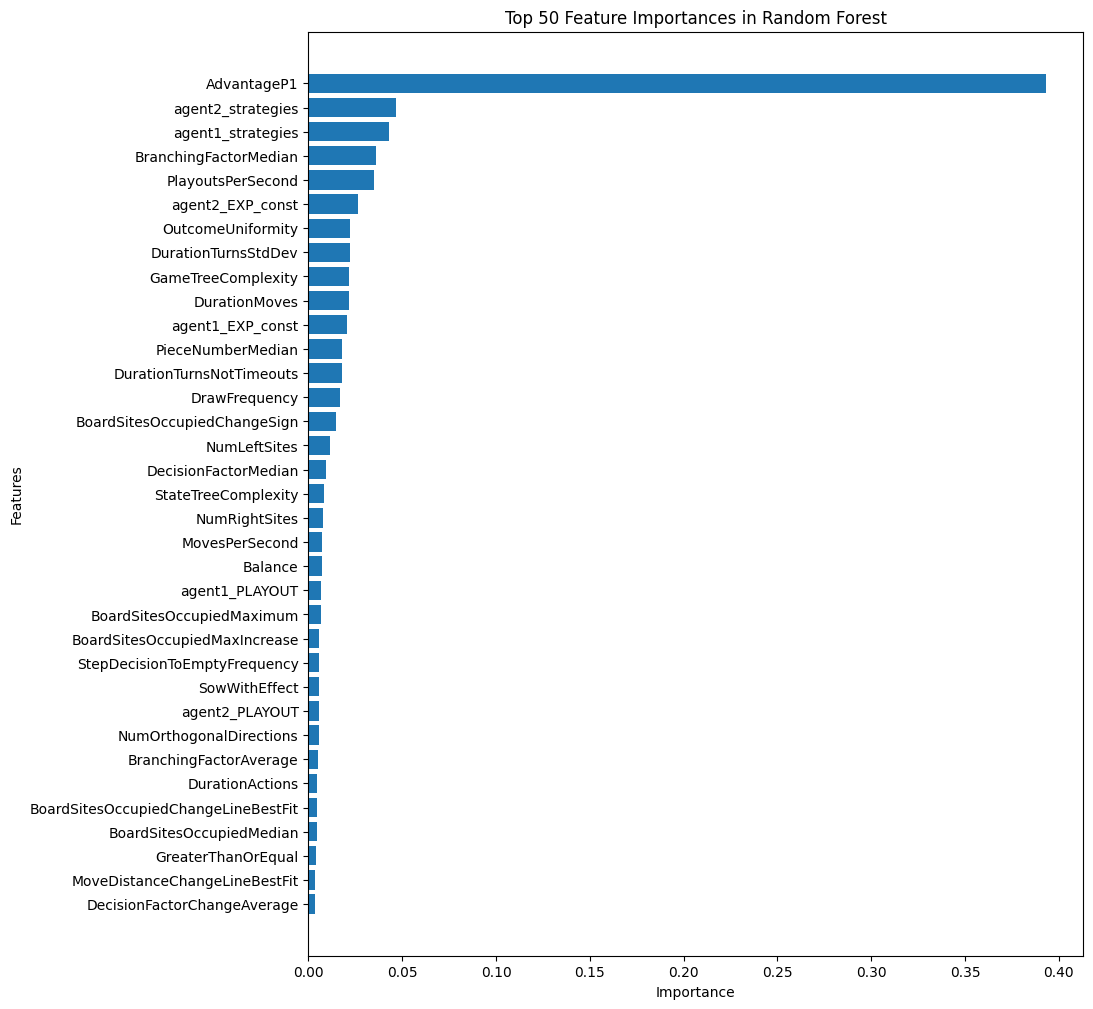

In [44]:
top_35_indices = np.argsort(importance)[-35:]

# Get the corresponding column names and importance values
RF_top_35_features = X.columns[top_35_indices]
top_35_importance = importance[top_35_indices]

# Plot the top 50 feature importances horizontally
plt.figure(figsize=(10, 12))  # Adjust figure size for better readability
plt.barh(range(35), top_35_importance, tick_label=RF_top_35_features)
plt.yticks(range(35), RF_top_35_features)
plt.title("Top 50 Feature Importances in Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [45]:
RF_top_35_features

Index(['DecisionFactorChangeAverage', 'MoveDistanceChangeLineBestFit',
       'GreaterThanOrEqual', 'BoardSitesOccupiedMedian',
       'BoardSitesOccupiedChangeLineBestFit', 'DurationActions',
       'BranchingFactorAverage', 'NumOrthogonalDirections', 'agent2_PLAYOUT',
       'SowWithEffect', 'StepDecisionToEmptyFrequency',
       'BoardSitesOccupiedMaxIncrease', 'BoardSitesOccupiedMaximum',
       'agent1_PLAYOUT', 'Balance', 'MovesPerSecond', 'NumRightSites',
       'StateTreeComplexity', 'DecisionFactorMedian', 'NumLeftSites',
       'BoardSitesOccupiedChangeSign', 'DrawFrequency',
       'DurationTurnsNotTimeouts', 'PieceNumberMedian', 'agent1_EXP_const',
       'DurationMoves', 'GameTreeComplexity', 'DurationTurnsStdDev',
       'OutcomeUniformity', 'agent2_EXP_const', 'PlayoutsPerSecond',
       'BranchingFactorMedian', 'agent1_strategies', 'agent2_strategies',
       'AdvantageP1'],
      dtype='object')

## xgboost

In [46]:
XGB = XGBRegressor(n_estimators=100,max_depth=10, random_state=42,n_jobs=-1)
XGB.fit(X, y)

XGB_importance = XGB.feature_importances_

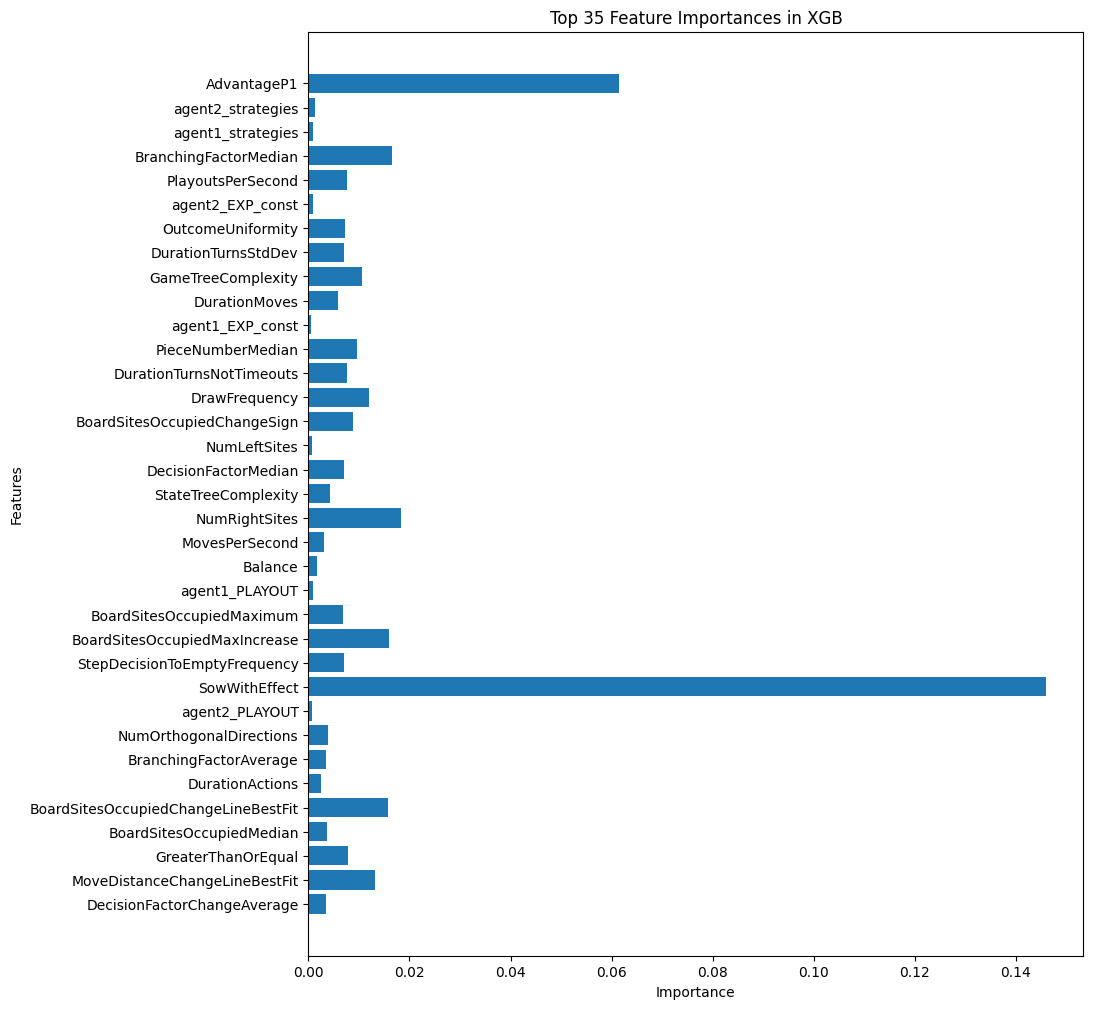

In [47]:
XGB_top_35_indices = np.argsort(XGB_importance)[-35:]

# Get the corresponding column names and importance values
XGB_top_35_features = X.columns[top_35_indices]
XGB_top_35_importance = XGB_importance[top_35_indices]

# Plot the top 50 feature importances horizontally
plt.figure(figsize=(10, 12))  # Adjust figure size for better readability
plt.barh(range(35), XGB_top_35_importance, tick_label=XGB_top_35_features)
plt.yticks(range(35), XGB_top_35_features)
plt.title("Top 35 Feature Importances in XGB")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [48]:
XGB_top_35_features

Index(['DecisionFactorChangeAverage', 'MoveDistanceChangeLineBestFit',
       'GreaterThanOrEqual', 'BoardSitesOccupiedMedian',
       'BoardSitesOccupiedChangeLineBestFit', 'DurationActions',
       'BranchingFactorAverage', 'NumOrthogonalDirections', 'agent2_PLAYOUT',
       'SowWithEffect', 'StepDecisionToEmptyFrequency',
       'BoardSitesOccupiedMaxIncrease', 'BoardSitesOccupiedMaximum',
       'agent1_PLAYOUT', 'Balance', 'MovesPerSecond', 'NumRightSites',
       'StateTreeComplexity', 'DecisionFactorMedian', 'NumLeftSites',
       'BoardSitesOccupiedChangeSign', 'DrawFrequency',
       'DurationTurnsNotTimeouts', 'PieceNumberMedian', 'agent1_EXP_const',
       'DurationMoves', 'GameTreeComplexity', 'DurationTurnsStdDev',
       'OutcomeUniformity', 'agent2_EXP_const', 'PlayoutsPerSecond',
       'BranchingFactorMedian', 'agent1_strategies', 'agent2_strategies',
       'AdvantageP1'],
      dtype='object')

## coollect features

In [49]:
list1 = list(lgb_important_features)
list2 = list(XGB_top_30_features)
list3 = list(RF_top_30_features)


In [50]:
combined_list = list(set(list1 + list2 +list3))

print(combined_list)

['PieceNumberMedian', 'agent2_PLAYOUT', 'MovesPerSecond', 'NumOuterSites', 'NumRightSites', 'agent2_EXP_const', 'AdvantageP1', 'agent1_PLAYOUT', 'DurationTurns', 'DecisionFactorChangeSign', 'OutcomeUniformity', 'BoardSitesOccupiedMaxIncrease', 'StateTreeComplexity', 'DecisionFactorMedian', 'DecisionMoves', 'SowWithEffect', 'agent1_EXP_const', 'PieceNumberVariance', 'agent1_strategies', 'NumLeftSites', 'BoardSitesOccupiedChangeSign', 'DurationActions', 'HopCaptureFrequency', 'StepDecisionToEmptyFrequency', 'BranchingFactorMaximum', 'GameRulesetName', 'NumStartComponentsHand', 'NumOrthogonalDirections', 'BranchingFactorVariance', 'DrawFrequency', 'Balance', 'BranchingFactorMedian', 'DurationTurnsNotTimeouts', 'DurationMoves', 'PlayoutsPerSecond', 'GameTreeComplexity', 'BoardSitesOccupiedChangeAverage', 'DurationTurnsStdDev', 'BranchingFactorAverage', 'BranchingFactorChangeAverage', 'agent2_strategies', 'BoardSitesOccupiedMaximum']


In [51]:
print(len(combined_list))

42
